In [ ]:
# Mount Google Drive to access files
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)

# Change the current directory to the script folder in Google Drive
# **NOTE:** You may need to change the path below to match your specific script location
os.chdir('drive/My Drive/tilt_recover')

# List the contents of the current directory to verify the change
os.listdir('.')

Mounted at /content/drive


['GT.npy',
 'IMG.npy',
 'test.tif',
 'pred.tif',
 '1758 83000 x 20250825.tif',
 '0144 - 20250824 83000 x 2113.tif',
 'unet_256x256_gray.keras',
 '0144 - 20250824 83000 x 2113_pred.tif',
 '1758 83000 x 20250825_pred.tif',
 '0027 - 20250818 2141-1.tif',
 '0027 - 20250818 2141_pred.tif',
 'Untitled0.ipynb']

In [ ]:
# Load training labels and images
import numpy as np
IMG = np.load('IMG.npy')
GT = np.load('GT.npy')

In [ ]:
print(IMG.shape)
print(GT.shape)

(2500, 256, 256)
(2500, 256, 256)


In [ ]:
# Define the U-Net model architecture, initialize, and train it
import tensorflow as tf

# --- data: IMG (inputs) and GT (targets), both float32 (b, 256, 256) ---
# Add channel dim -> (b, 256, 256, 1)
x = IMG[..., None].astype(np.float32)
y = GT[..., None].astype(np.float32)

# Simple tf.data pipeline
batch_size = 8
ds = tf.data.Dataset.from_tensor_slices((x, y)).shuffle(len(x)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

def conv_block(x, filters):
    x = tf.keras.layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    x = tf.keras.layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    return x

def build_unet(input_shape=(256, 256, 1)):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    c1 = conv_block(inputs, 64)
    p1 = tf.keras.layers.MaxPool2D()(c1)

    c2 = conv_block(p1, 128)
    p2 = tf.keras.layers.MaxPool2D()(c2)

    c3 = conv_block(p2, 256)
    p3 = tf.keras.layers.MaxPool2D()(c3)

    c4 = conv_block(p3, 512)
    p4 = tf.keras.layers.MaxPool2D()(c4)

    # Bottleneck
    bn = conv_block(p4, 1024)

    # Decoder
    u4 = tf.keras.layers.Conv2DTranspose(512, 2, strides=2, padding="same")(bn)
    u4 = tf.keras.layers.Concatenate()([u4, c4])
    c5 = conv_block(u4, 512)

    u3 = tf.keras.layers.Conv2DTranspose(256, 2, strides=2, padding="same")(c5)
    u3 = tf.keras.layers.Concatenate()([u3, c3])
    c6 = conv_block(u3, 256)

    u2 = tf.keras.layers.Conv2DTranspose(128, 2, strides=2, padding="same")(c6)
    u2 = tf.keras.layers.Concatenate()([u2, c2])
    c7 = conv_block(u2, 128)

    u1 = tf.keras.layers.Conv2DTranspose(64, 2, strides=2, padding="same")(c7)
    u1 = tf.keras.layers.Concatenate()([u1, c1])
    c8 = conv_block(u1, 64)

    # Linear output for grayscale regression (no activation)
    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation=None)(c8)

    model = tf.keras.Model(inputs, outputs, name="unet_256x256_gray")
    return model

model = build_unet()
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="mse")

# Train
model.fit(ds, epochs=20)
model.save("unet_256x256_gray.keras")


Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 57s 91ms/step - loss: 0.0541
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - loss: 0.0060
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - loss: 0.0013
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - loss: 0.0016
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - loss: 0.0010
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - loss: 7.1005e-04
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - loss: 6.1671e-04
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - loss: 5.2226e-04
Epoch 9/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - loss: 5.1285e-04
Epoch 10/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - loss: 8.4234e-04
Epoch 11/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - loss: 3.8064e-04
Epoch 12/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - loss: 5.2576e-04
Epoch 13/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - loss: 0.0059
Epoch 14/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - loss: 6.6908e-

In [ ]:
import numpy as np
import tifffile as tiff
import tensorflow as tf

# --- load your trained model ---
# If you already have `model` in memory, comment the next line.
model = tf.keras.models.load_model("unet_256x256_gray.keras", compile=False)

Run prediction on three datasets

In [ ]:
import tifffile as tiff
# --- read input stack (expects float32, shape: (N, 256, 256)) ---
inp = tiff.imread("0144 - 20250824 83000 x 2113.tif")
inp = np.asarray(inp, dtype=np.float32)
assert inp.ndim == 3 and inp.shape[1:] == (256, 256), f"Got shape {inp.shape}, expected (N,256,256)"

# --- add channel dim -> (N, 256, 256, 1) ---
x = inp[..., None]

# --- predict in batches ---
batch_size = 16
pred = model.predict(x, batch_size=batch_size, verbose=1)   # (N,256,256,1)
pred = np.squeeze(pred, axis=-1).astype(np.float32)         # (N,256,256), float32

# --- save output stack as 32-bit float tiff ---
tiff.imwrite("0144 - 20250824 83000 x 2113_pred.tif", pred)

print("Wrote pred.tif with shape", pred.shape, "and dtype", pred.dtype)

20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 248ms/step
Wrote pred.tif with shape (311, 256, 256) and dtype float32


In [ ]:
import tifffile as tiff
# --- read input stack (expects float32, shape: (N, 256, 256)) ---
inp = tiff.imread("1758 83000 x 20250825.tif")
inp = np.asarray(inp, dtype=np.float32)
assert inp.ndim == 3 and inp.shape[1:] == (256, 256), f"Got shape {inp.shape}, expected (N,256,256)"

# --- add channel dim -> (N, 256, 256, 1) ---
x = inp[..., None]

# --- predict in batches ---
batch_size = 16
pred = model.predict(x, batch_size=batch_size, verbose=1)   # (N,256,256,1)
pred = np.squeeze(pred, axis=-1).astype(np.float32)         # (N,256,256), float32

# --- save output stack as 32-bit float tiff ---
tiff.imwrite("1758 83000 x 20250825_pred.tif", pred)

print("Wrote pred.tif with shape", pred.shape, "and dtype", pred.dtype)

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 274ms/step
Wrote pred.tif with shape (178, 256, 256) and dtype float32


In [ ]:
import tifffile as tiff
# --- read input stack (expects float32, shape: (N, 256, 256)) ---
inp = tiff.imread("0027 - 20250818 2141-1.tif")
inp = np.asarray(inp, dtype=np.float32)
assert inp.ndim == 3 and inp.shape[1:] == (256, 256), f"Got shape {inp.shape}, expected (N,256,256)"

# --- add channel dim -> (N, 256, 256, 1) ---
x = inp[..., None]

# --- predict in batches ---
batch_size = 16
pred = model.predict(x, batch_size=batch_size, verbose=1)   # (N,256,256,1)
pred = np.squeeze(pred, axis=-1).astype(np.float32)         # (N,256,256), float32

# --- save output stack as 32-bit float tiff ---
tiff.imwrite("0027 - 20250818 2141.tif", pred)

print("Wrote pred.tif with shape", pred.shape, "and dtype", pred.dtype)

4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step
Wrote pred.tif with shape (59, 256, 256) and dtype float32


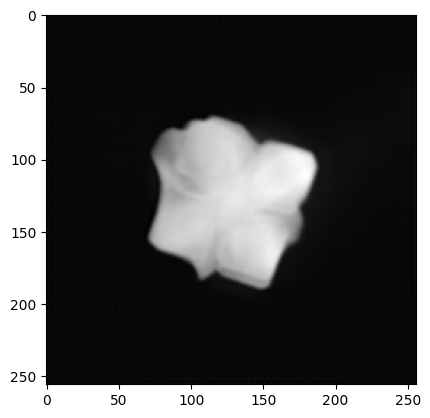

In [ ]:
# Sanity check
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(pred[25,:,:], cmap = 'gray')